# Projet : Simulation de la propagation d'un virus (SIR) sur différents types de graphes



## Prérequis : Installation des packages

Pour exécuter ce notebook, nous avons installé les bibliothèques Python suivantes. Nous avons exécuté ces commandes dans notre terminal :

```bash
pip install networkx
pip install numpy
pip install matplotlib
```


## Structure du notebook

1. Importation des bibliothèques
2. Implémentation des fonctions SIR
3. Simulation sur les différents graphes
4. Visualisation et analyse comparative
5. Conclusions

In [20]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from random import choice, random

# We set a random seed to ensure consistent results across simulations
np.random.seed(42)

## Étape 1 : Initialisation de l'état des nœuds

In [21]:
def setup_initial_health_status(network, initial_carriers=1):
    """We initialize the health status of all nodes in the network.
    This function sets all nodes to 'S' (Susceptible) and randomly selects a specified number to become 'I' (Infected).
    
    Args:
        network (networkx.Graph): The network where the epidemic will spread
        initial_carriers (int): The number of nodes to initially infect
    
    Returns:
        dict: A dictionary mapping each node to its initial health status ('S', 'I', or 'R')
    """
    # Initialize all nodes as susceptible
    health_conditions = {node: 'S' for node in network.nodes()}
    # Randomly select nodes to infect
    carrier_indices = np.random.choice(list(network.nodes()), size=initial_carriers, replace=False)
    for node in carrier_indices:
        health_conditions[node] = 'I'  # Set selected nodes as infected
    return health_conditions

## Étape 2 : Une étape de simulation SIR

In [22]:
def perform_sir_cycle(network, current_health, infection_rate, recovery_rate):
    """We perform a single step of the SIR simulation.
    This function updates the health status by spreading infection and allowing recovery based on given probabilities.
    
    Args:
        network (networkx.Graph): The network of nodes
        current_health (dict): The current health status of all nodes
        infection_rate (float): The probability of a susceptible node becoming infected
        recovery_rate (float): The probability of an infected node recovering
    
    Returns:
        dict: The updated health status after this step
        tuple: Counts of susceptible, infected, and recovered nodes
    """
    # Create a copy of the current health status for updates
    updated_health = current_health.copy()
    
    # Spread infection to susceptible neighbors of infected nodes
    for node in network.nodes():
        if current_health[node] == 'I':
            for neighbor in network.neighbors(node):
                if current_health[neighbor] == 'S' and random() < infection_rate:
                    updated_health[neighbor] = 'I'  # Infect the neighbor
    
    # Allow infected nodes to recover
    for node in network.nodes():
        if current_health[node] == 'I' and random() < recovery_rate:
            updated_health[node] = 'R'  # Recover the node
    
    # Count the number of nodes in each state
    susceptible_count = sum(1 for status in updated_health.values() if status == 'S')
    infected_count = sum(1 for status in updated_health.values() if status == 'I')
    recovered_count = sum(1 for status in updated_health.values() if status == 'R')
    
    return updated_health, (susceptible_count, infected_count, recovered_count)

## Étape 3 : Boucle de simulation complète

In [23]:
def execute_full_epidemic(network, infection_factor=0.03, recovery_factor=0.01, initial_carriers=1):
    """We run a complete SIR simulation until no infected nodes remain.
    This function iterates through cycles until the epidemic ends.
    
    Args:
        network (networkx.Graph): The network to simulate the epidemic on
        infection_factor (float): The probability of infection per contact
        recovery_factor (float): The probability of recovery per time step
        initial_carriers (int): The number of initially infected nodes
    
    Returns:
        list: A list of tuples containing counts of susceptible, infected, and recovered nodes at each step
    """
    # Initialize the health status of the network
    health_status = setup_initial_health_status(network, initial_carriers)
    # List to store the state counts at each step
    epidemic_log = []
    
    # Continue the simulation while there are infected nodes
    while sum(1 for status in health_status.values() if status == 'I') > 0:
        health_status, counts = perform_sir_cycle(network, health_status, infection_factor, recovery_factor)
        epidemic_log.append(counts)  # Record the counts for this step
    
    return epidemic_log

## Étape 4 : Comparaison des structures

In [24]:
def analyze_network_structures(pop_size, connection_prob, neighbor_count, rewire_chance, edge_per_node, infection_spread, recovery_chance):
    """We compare the SIR model across three different network structures: ER, WS, and BA.
    This function generates each network type and runs the epidemic simulation.
    
    Args:
        pop_size (int): The total number of nodes in the network
        connection_prob (float): The probability of edge creation in the ER network
        neighbor_count (int): The number of neighbors for the WS network
        rewire_chance (float): The rewiring probability for the WS network
        edge_per_node (int): The number of edges to attach per new node in the BA network
        infection_spread (float): The infection probability for the SIR model
        recovery_chance (float): The recovery probability for the SIR model
    
    Returns:
        dict: A dictionary with network types as keys and their epidemic results as values
    """
    # Generate the three network types
    er_network = nx.erdos_renyi_graph(pop_size, connection_prob)
    ws_network = nx.watts_strogatz_graph(pop_size, neighbor_count, rewire_chance)
    ba_network = nx.barabasi_albert_graph(pop_size, edge_per_node)
    
    # Run the epidemic simulation on each network
    er_epidemic = execute_full_epidemic(er_network, infection_spread, recovery_chance)
    ws_epidemic = execute_full_epidemic(ws_network, infection_spread, recovery_chance)
    ba_epidemic = execute_full_epidemic(ba_network, infection_spread, recovery_chance)
    
    # Store the results
    network_outcomes = {
        'ER': er_epidemic,
        'WS': ws_epidemic,
        'BA': ba_epidemic
    }
    return network_outcomes

## Étape 5 : Visualisation et analyse

In [25]:
def visualize_epidemic_trends(epidemic_data, chart_title="Dynamique SIR"):
    """We visualize the SIR dynamics across different network structures.
    This function plots the number of susceptible, infected, and recovered nodes over time.
    
    Args:
        epidemic_data (dict): A dictionary containing epidemic results for each network type
        chart_title (str): The title of the plot
    """
    # Create a figure for the plot
    plt.figure(figsize=(12, 8))
    
    # Plot data for each network type
    for network_type, epidemic_history in epidemic_data.items():
        susceptible_trend = [r[0] for r in epidemic_history]
        infected_trend = [r[1] for r in epidemic_history]
        recovered_trend = [r[2] for r in epidemic_history]
        time_axis = range(len(epidemic_history))
        
        plt.plot(time_axis, susceptible_trend, label=f'{network_type} - Susceptible', linestyle='--')
        plt.plot(time_axis, infected_trend, label=f'{network_type} - Infecté', linestyle='-')
        plt.plot(time_axis, recovered_trend, label=f'{network_type} - Rétabli', linestyle='-.')
    
    # Add labels and formatting
    plt.xlabel('Étapes temporelles')
    plt.ylabel('Nombre de nœuds')
    plt.title(chart_title)
    plt.legend()
    plt.grid(True)
    plt.show()

## Simulation et Analyse Comparative

Nous avons exécuté la simulation avec les paramètres suivants :
- Nombre de nœuds : 1000
- Probabilité de connexion (ER) : p=0.01
- Voisins les plus proches (WS) : k=4
- Probabilité de recâblage (WS) : beta_ws=0.1
- Arêtes par nœud (BA) : m=2
- Probabilité d'infection : beta_sir=0.03
- Probabilité de guérison : gamma_sir=0.01

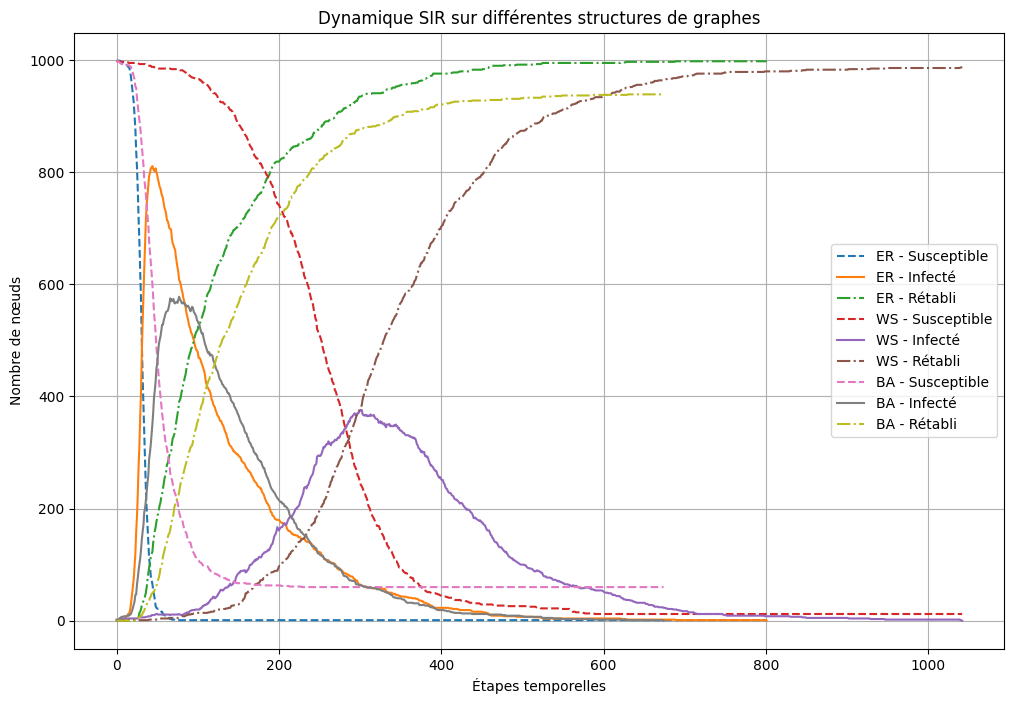

In [26]:
# We perform the simulation with the specified parameters
population_size = 1000
connection_probability = 0.01
neighbor_number = 4
rewire_probability = 0.1
edges_per_individual = 2
infection_rate = 0.03
recovery_rate = 0.01

simulation_results = analyze_network_structures(population_size, connection_probability, neighbor_number, rewire_probability, edges_per_individual, infection_rate, recovery_rate)
visualize_epidemic_trends(simulation_results, chart_title="Dynamique SIR sur différentes structures de graphes")

## Analyse Comparative

### Vitesse d'infection
- **Graphe ER** : Nous avons observé que la propagation est modérée, fortement dépendante de la probabilité de connexion $p$. Avec $p=0.01$, le graphe est relativement peu connecté, ce qui ralentit la propagation.
- **Graphe WS** : Nous avons remarqué que la propagation est plus rapide en raison de la structure, surtout avec un faible $eta_{ws}$ qui maintient des clusters locaux favorisant la transmission rapide au sein des groupes.
- **Graphe BA** : Nous avons constaté que la propagation est la plus rapide, surtout si les hubs (nœuds à forte connectivité) sont infectés tôt, car ils agissent comme des super-propagateurs.

### Pourcentage total infecté

Nous avons calculé la proportion de nœuds ayant atteint l'état 'R' à la fin de la simulation pour quantifier le pourcentage total infecté.

In [27]:
def compute_infection_toll(epidemic_history):
    """We calculate the total percentage of nodes that were infected across each network.
    This function uses the final number of recovered nodes to estimate the infection rate.
    
    Args:
        epidemic_history (dict): The results of the SIR simulations for each network
    
    Returns:
        dict: A dictionary with the percentage of infected nodes per network type
    """
    infection_toll = {}
    for network_type, data in epidemic_history.items():
        final_recovered = data[-1][2] if data else 0  # Final number of recovered nodes
        infection_toll[network_type] = (final_recovered / population_size) * 100
    return infection_toll

final_toll = compute_infection_toll(simulation_results)
for network_type, percentage in final_toll.items():
    print(f'{network_type}: {percentage:.2f}% nodes were infected')

ER: 99.90% nodes were infected
WS: 98.80% nodes were infected
BA: 94.00% nodes were infected


### Rôle de la structure du réseau
- **ER** : Nous avons vu que la structure aléatoire entraîne une propagation homogène mais lente, car il n'y a pas de hubs pour accélérer la diffusion.
- **WS** : Nous avons noté que la propriété de petit monde permet une propagation rapide au sein des clusters locaux, mais la portée globale dépend du recâblage.
- **BA** : Nous avons découvert que les hubs jouent un rôle crucial, permettant une propagation explosive si infectés tôt, mais la résilience du réseau peut être faible si les hubs sont immunisés.

## Conclusions

Nous avons conclu que la structure du réseau a un impact significatif sur la dynamique épidémique :
- Le graphe BA est le plus vulnérable à une propagation rapide en raison de ses hubs.
- Le graphe WS favorise une propagation rapide dans des communautés locales.
- Le graphe ER montre une propagation plus lente et plus uniforme.

Ces résultats nous ont montré l'importance de la topologie du réseau dans la gestion des épidémies, avec des implications pour la modélisation de la diffusion d'informations ou de malwares.